#### For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [83]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [84]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [85]:
llm.invoke("hi")

AIMessage(content='Hi! 👋  What can I do for you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 0.001168471, 'queue_time': 0.262938651, 'total_time': 0.028441198}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--1b243d23-d5e4-4332-bfe7-22c5e7c5ad82-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})

In [86]:
llm.invoke("hi").content

'Hi there! 👋\n\nHow can I help you today?\n'

In [87]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [88]:
multiply({"first_number":24,"second_number":364})

8736

In [89]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [90]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [91]:
search("who is a current president of USA?")

[{'title': 'President of the United States - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'In all, 45 individuals have served 47 presidencies spanning 60 four-year terms. Donald Trump is the 47th and current president since January 20, 2025.',
  'score': 0.81489426},
 {'title': 'The White House',
  'url': 'https://www.whitehouse.gov/',
  'content': 'Donald J. Trump. President of the United States · JD Vance. VICE PRESIDENT OF THE UNITED STATES · Melania Trump. First Lady OF THE UNITED STATES · The Cabinet. Of',
  'score': 0.644248},
 {'title': 'President Donald J. Trump - The White House',
  'url': 'https://www.whitehouse.gov/administration/donald-j-trump/',
  'content': 'After a landslide election victory in 2024, President Donald J. Trump is returning to the White House to build upon his previous successes and use his',
  'score': 0.54274267},
 {'title': 'President Trump Announces Presidential Delegation to Osaka ...',
  'url': 'ht

In [92]:
search.invoke("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. H

In [93]:
tools=[search,multiply]

In [94]:
model_with_tools = llm.bind_tools(tools)

In [95]:
tool_mapping={tool.name: tool for tool in tools}

In [96]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000023DB07F5F80>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000023DB07F5440>)}

In [97]:
response = model_with_tools.invoke("who is a current president of USA?")

In [98]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x2td1rqb0', 'function': {'arguments': '{"query":"who is the current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1075, 'total_tokens': 1159, 'completion_time': 0.152727273, 'prompt_time': 0.020383678, 'queue_time': 0.265232181, 'total_time': 0.173110951}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--43f13891-bc7c-4ac4-9e36-2b83acbf886b-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of USA'}, 'id': 'x2td1rqb0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 84, 'total_tokens': 1159})

In [99]:
tool_details=response.additional_kwargs.get("tool_calls")

In [100]:
tool_details

[{'id': 'x2td1rqb0',
  'function': {'arguments': '{"query":"who is the current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [101]:
tool_details[0]["function"]["name"]

'search'

In [102]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of USA"}'

In [103]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the current president of USA'}

In [104]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'President of the United States - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is elected indirectly through the Electoral College to a four-year term, along with the vice president. Under the Twenty-second Amendment, ratified in 1951, no person who has been elected to two presidential terms may be elected to a third. In addition, nine vice presidents have become president by virtue of a president\'s intra-term death or resignation. In all, 45 individuals have served 47 presidencies spanning 60 four-year terms. Donald Trump is the 47th and current president [...] | President of the United States | |\n| --- | --- |\n| Presidential seal | |\n| Presidential flag | |\n| Incumbent Donald Trump since January 20, 2025 | |\n|  Executive branch of the U.S. government  Executive Office of the President | |\n| Style "Style (form of address)") |  Mr. President "President (government title)") (informal)  The Honorable (f

In [105]:
class AgentState(TypedDict): ## it is going to capture the message
    messages: Annotated[Sequence[BaseMessage], operator.add] ## we capture the message in the form of list

In [106]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [107]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments"))) 
    return {"messages" : [response]}

In [108]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [109]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [110]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [111]:
app = graph.compile()

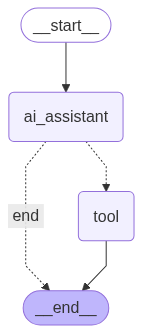

In [112]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [113]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bxbjkwkcx', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1074, 'total_tokens': 1157, 'completion_time': 0.150909091, 'prompt_time': 0.021098168, 'queue_time': 0.269180671, 'total_time': 0.172007259}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09461085-651b-40ad-830d-127bb568063f-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'bxbjkwkcx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1074, 'output_tokens': 83, 'total_tokens': 1157})]}
----
Selected tool: search
{'messages': [[{'title': 'United States presidential line of succession - Simple Wikipedia', 'url': 'https://simple.wikipedia.org/wiki/United_States_presidential_line_of_succession

In [114]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='<tool_call>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "multiply"\n\t\t},\n\t\t"parameters": {\n\t\t\t"first_number": 23,\n\t\t\t"second_number": 46\n\t\t}\n\t}\n}\n</tool_call>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1079, 'total_tokens': 1170, 'completion_time': 0.165454545, 'prompt_time': 0.020384118, 'queue_time': 0.266111356, 'total_time': 0.185838663}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--e6499c75-7253-42e4-9c8b-905ac6c9832a-0', usage_metadata={'input_tokens': 1079, 'output_tokens': 91, 'total_tokens': 1170})]}
----


In [115]:
for s in app.stream({"messages": ["what is the total amount of money exist over the earth?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c2g08dhja', 'function': {'arguments': '{"query":"What is the total amount of money in circulation in the world?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1079, 'total_tokens': 1170, 'completion_time': 0.165454545, 'prompt_time': 0.020386506, 'queue_time': 0.26678495199999996, 'total_time': 0.185841051}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09cd35cd-88a1-43ef-94de-ef9cf138a772-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is the total amount of money in circulation in the world?'}, 'id': 'c2g08dhja', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 91, 'total_tokens': 1170})]}
----
Selected tool: search
{'messages': [[{'title': 'How Much Money Is in the World Right Now? - AOL.com', 'url': 'https://ww

#### LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

In [116]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [117]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [118]:
tavily=TavilySearchResults()

In [119]:
tools = [tavily]

In [120]:
llm_with_tools = llm.bind_tools(tools)

In [121]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [122]:
memory = MemorySaver()

In [123]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [124]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [125]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

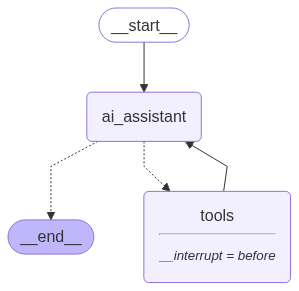

In [126]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [127]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [128]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [129]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mwcxksxrk)
 Call ID: mwcxksxrk
  Args:
    query: capital of india


In [130]:
snapshot = app2.get_state(config)

In [131]:
snapshot.next

('tools',)

In [132]:
last_message=snapshot.values["messages"][-1]

In [133]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'capital of india'},
  'id': 'mwcxksxrk',
  'type': 'tool_call'}]

In [134]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [135]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mwcxksxrk)
 Call ID: mwcxksxrk
  Args:
    query: capital of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "New Delhi - Wikipedia", "url": "https://en.wikipedia.org/wiki/New_Delhi", "content": "Appearance\n\nmove to sidebar hide\n\nCoordinates: 28°36′50″N 77°12′32″E / 28.61389°N 77.20889°E / 28.61389; 77.20889\n\nImage 4: Page semi-protected\n\nFrom Wikipedia, the free encyclopedia\n\nCapital city of India\n\nThis article is about the capital of India, within the union territory of Delhi. For other uses, see New Delhi (disambiguation) \"New Delhi (disambiguation)\"). [...] New Delhi (/ˈ nj uː ˈ d ɛ.l i/ⓘ;( _\\_\\\\_Naī Dillī\\\\_\\__, pronounced( \"Help:IPA/Hindi and Urdu\")) is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat

In [136]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [137]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [138]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (znf1m4f8p)
 Call ID: znf1m4f8p
  Args:
    query: weather in New Delhi


In [139]:
snapshot = app2.get_state(config)

In [140]:
snapshot.next

('tools',)

In [141]:
last_message=snapshot.values["messages"][-1]

In [142]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in New Delhi'},
  'id': 'znf1m4f8p',
  'type': 'tool_call'}]

In [143]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [144]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (znf1m4f8p)
 Call ID: znf1m4f8p
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "New Delhi July 2025 Historical Weather Data (NCT, India)", "url": "https://weatherspark.com/h/m/109174/2025/7/Historical-Weather-in-July-2025-in-New-Delhi-NCT-India", "content": "95Â°F sweltering   |  |  | | --- | --- | | Dew Pt. | 79Â°F  miserable | | Rel. Humidity | 60% |  Precipitation  No Report  Wind  9.2 mph gentle breeze   |  |  | | --- | --- | | Wind Dir. | 110 deg, ESE |  Cloud Cover  Partly Cloudy  3,000 ft   |  |  | | --- | --- | |  | Mostly Clear 3,500 ft | |  | Partly Cloudy 10,000 ft |   |  |  | | --- | --- | | Vis. | 3.11 mi | | Alt. | 29.50 inHg |  Raw: VIDP 030830Z 11008KT 070V140 5000 HZ SCT030 FEW035CB SCT100 35/26 Q0999 NOSIG  This report shows the [.

In [145]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='b4c2997c-e8d3-4729-8412-9e25c8753853'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mwcxksxrk', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 988, 'total_tokens': 1077, 'completion_time': 0.161818182, 'prompt_time': 0.020970827, 'queue_time': 0.265227736, 'total_time': 0.182789009}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b18b72e9-67d7-421b-9606-7b3330d6af31-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'mwcxksxrk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 988, 'output_tokens': 89, 'total_tokens': 1077}), ToolMessage(content

In [146]:
snapshot=app2.get_state(config)

In [147]:
snapshot.next

()

In [148]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [149]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [150]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================

```json
```


```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```

```
```


```



```
```
```
```
```


```



```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```


```
```
```
```
```
```
```
```
```



```


```



```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
``

In [151]:
snapshot=app2.get_state(config)

In [152]:
current_message = snapshot.values["messages"][-1]

In [153]:
current_message.pretty_print()

================================== Ai Message ==================================

```json
```


```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```

```
```


```



```
```
```
```
```


```



```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```


```
```
```
```
```
```
```
```
```



```


```



```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```



```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```
```



```
```
```


```
```
```
```
```
```
```
```


```
```
```


In [154]:
tool_call_id = current_message.tool_calls[0]["id"] 

IndexError: list index out of range

In [ ]:
tool_call_id

'call_k054'

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

In [ ]:
answer = "it is just related to raining which is happing on daily basis"

In [ ]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [ ]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa3f9e-a414-6c0a-800e-b3cf9a8c9199'}}

In [ ]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='86ee0c6d-7771-4ed6-8bd2-242adace39be')]
